### Uploading to S3

In [51]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import json 

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

# Constants
CITIES = {'iq': 0, 'sj': 1} # Categorical variable encoding
PREDICTION_LENGTH = {'iq': 156, 'sj': 260} # Prediction length is fixed by the test set

### Change tag to jobnames
tag = 'only-target-optim'
timestamp = pd.Timestamp.now().strftime("%Y-%m-%d--%H-%M")

model_version = f'{timestamp}-{tag}' # can be set to a specific job
model_comments = "baseline with only target but longer learning - optim HP"

prefix='dengai'
raw_prefix = f'{prefix}/raw_data'
pprocess_prefix = f'{prefix}/{model_version}/pprocess_data'
model_prefix = f'{prefix}/{model_version}/models'
batch_transform_prefix = f'{prefix}/{model_version}/batch-transform'

In [52]:
model_info_keys = [
    'model_version',
    'comments',
    "epochs",
    "time_freq",
    "num_cells",
    "num_layers",
    "mini_batch_size",
    "learning_rate",
    "early_stopping_patience",
    'prediction_length',
    'context_length',
    'MAE_iq',
    'MAE_sj',
    'MAE_total']

current_model_info = dict.fromkeys(model_info_keys)

def dict_update(base_dict, update_dict):
    base_dict.update((k, update_dict[k]) for k in base_dict.keys() & update_dict.keys())

dict_update(current_model_info, {'model_version': model_version, 'comments': model_comments})

In [53]:
if len(sagemaker_session.list_s3_files(bucket, raw_prefix))<4:
    ! wget -nc https://s3.amazonaws.com/drivendata-prod/data/44/public/dengue_features_train.csv -P ./data/input
    ! wget -nc https://s3.amazonaws.com/drivendata-prod/data/44/public/dengue_labels_train.csv -P ./data/input
    ! wget -nc https://s3.amazonaws.com/drivendata-prod/data/44/public/dengue_features_test.csv -P ./data/input
    ! wget -nc https://s3.amazonaws.com/drivendata-prod/data/44/public/submission_format.csv -P ./data/input  
    s3_uri = sagemaker_session.upload_data('./data/input', bucket, raw_prefix)
    print(f'Uploaded raw files to {s3_uri}')

In [54]:
from sagemaker.processing import ScriptProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

sklearn_processor = ScriptProcessor(image_uri='964501460451.dkr.ecr.eu-central-1.amazonaws.com/sagemaker-containers:updated-sklearn_0.22.0-cpu-py3',
                                     role=role,
                                     instance_type='ml.m4.xlarge',
                                     instance_count=1,
                                     command = ["python3"], # default required using the same as in SKLearnProcessor
                                     volume_size_in_gb=30, # default required using the same as in SKLearnProcessor
                                     base_job_name=f'{prefix}-{tag}-pprocess'
                                    )

sklearn_processor.run(code='src/preprocessing.py',
                      inputs=[
                          ProcessingInput(
                              source=f's3://{bucket}/{raw_prefix}',
                              input_name='input_data',
                              destination='/opt/ml/processing/input')
                      ],
                      outputs=[
                          ProcessingOutput(
                              source='/opt/ml/processing/output',
                              output_name='output_data',
                              destination=f's3://{bucket}/{pprocess_prefix}')                
                      ]
                     )

preprocessing_job_description = sklearn_processor.jobs[-1].describe()
output_config = preprocessing_job_description['ProcessingOutputConfig']


Job Name:  dengai-only-target-optim-pprocess-2020-04-19-12-42-47-783
Inputs:  [{'InputName': 'input_data', 'S3Input': {'S3Uri': 's3://sagemaker-eu-central-1-964501460451/dengai/raw_data', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-eu-central-1-964501460451/dengai-only-target-optim-pprocess-2020-04-19-12-42-47-783/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'output_data', 'S3Output': {'S3Uri': 's3://sagemaker-eu-central-1-964501460451/dengai/2020-04-19--12-42-only-target-optim/pprocess_data', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
........................
Received arguments Namespace(context_len

In [55]:
preprocessed_data = f's3://{bucket}/{pprocess_prefix}'

train_path = f'{preprocessed_data}/train_pp.json'
train_path_sj = f'{preprocessed_data}/train_pp_sj.json'
train_path_iq = f'{preprocessed_data}/train_pp_iq.json'

train_test_path_sj = f'{preprocessed_data}/train_test_pp_sj.json'
train_test_path_iq = f'{preprocessed_data}/train_test_pp_iq.json'

validation_path_sj = f'{preprocessed_data}/validation_pp_sj.json'
validation_path_iq = f'{preprocessed_data}/validation_pp_iq.json'


submission_train_path_sj = f'{preprocessed_data}/submission_train_pp_sj.json'
submission_train_path_iq = f'{preprocessed_data}/submission_train_pp_iq.json'

submission_test_path_sj = f'{preprocessed_data}/submission_test_pp_sj.json'
submission_test_path_iq = f'{preprocessed_data}/submission_test_pp_iq.json'

### Creating training job

In [56]:
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator
import csv

image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar') 
s3_output_path_model = f's3://{bucket}/{model_prefix}'

def fit_model(train_path, test_path, base_job_name, hyperparameters=None):
    image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')    
    estimator = Estimator(sagemaker_session=sagemaker_session,
                            image_name=image_name,
                            role=role,
                            train_instance_count=1,
                            train_instance_type='ml.c4.xlarge',
                            output_path=s3_output_path_model,
                            base_job_name=base_job_name,
                            train_use_spot_instances=True,
                            train_max_wait=60*60,
                            train_max_run=60*60
                         )
    
    hyperparameters_base = {
        "epochs": "250",
        "time_freq": 'W',
        "num_cells": "128",
        "num_layers": "2",
        "mini_batch_size": "64",
        "learning_rate": "0.005",
        "dropout_rate": "0.01",
        "early_stopping_patience": "25",
        'prediction_length': hyperparameters['prediction_length'],
        'context_length': 52,
        'num_dynamic_feat': 'auto',
        'cardinality': 'auto'}
    dict_update(hyperparameters_base, hyperparameters)
    
    dict_update(current_model_info, hyperparameters_base)
    
    data_channels = {'train': train_path}
    if test_path:
        data_channels['test'] = test_path
    
    estimator.set_hyperparameters(**hyperparameters_base)
    estimator.fit(inputs=data_channels, wait=False)
    return estimator.latest_training_job.name

estimator_sj_training_job = fit_model(train_path_sj,
                                      train_test_path_sj,
                                      f'{prefix}-{tag}-sj',
                                      {'prediction_length': str(PREDICTION_LENGTH['sj'])})
estimator_iq_training_job = fit_model(train_path_iq,
                                      train_test_path_iq,
                                      f'{prefix}-{tag}-iq',
                                      {'prediction_length': str(PREDICTION_LENGTH['iq']),
                                      'num_cells': '64',
                                      'context_length': '32'})

print(estimator_sj_training_job)
print(estimator_iq_training_job)

estimator_sj = Estimator.attach(estimator_sj_training_job)
estimator_iq = Estimator.attach(estimator_iq_training_job)

dengai-only-target-optim-sj-2020-04-19-12-47-00-833
dengai-only-target-optim-iq-2020-04-19-12-47-01-020
2020-04-19 12:47:02 Starting - Launching requested ML instances......
2020-04-19 12:47:58 Starting - Preparing the instances for training.........
2020-04-19 12:49:22 Downloading - Downloading input data...
2020-04-19 12:49:56 Training - Training image download completed. Training in progress.Arguments: train
[04/19/2020 12:49:58 INFO 139636288943936] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likeliho

## Testing our model

### Batch transform

In [57]:
import os
from sagemaker.transformer import Transformer

s3_batch_output_path = f's3://{bucket}/{batch_transform_prefix}'

def batch_transform(estimator, data_path):
    transformer = estimator.transformer(instance_count=1,
                                    instance_type='ml.m4.xlarge',
                                    strategy='SingleRecord',
                                    assemble_with='Line',
                                    output_path=s3_batch_output_path)
    print(f'Transformer created from {estimator.latest_training_job.job_name}')
    transformer.transform(data=data_path,
                          data_type='S3Prefix',
                          content_type=None,
                          split_type='Line',
                          wait=False,
                          logs=True)
    print(f'> Transform job {transformer.latest_transform_job.name} created with data: {data_path}')
    return transformer.latest_transform_job.name
    


transformer_sj_job = batch_transform(estimator_sj, validation_path_sj)
transformer_iq_job = batch_transform(estimator_iq, validation_path_iq)

transformer_sj = Transformer.attach(transformer_sj_job).wait()
transformer_iq = Transformer.attach(transformer_iq_job).wait()

Transformer created from dengai-only-target-optim-sj-2020-04-19-12-47-00-833
> Transform job dengai-only-target-optim-sj-2020-04-19--2020-04-19-13-50-33-619 created with data: s3://sagemaker-eu-central-1-964501460451/dengai/2020-04-19--12-42-only-target-optim/pprocess_data/validation_pp_sj.json
Transformer created from dengai-only-target-optim-iq-2020-04-19-12-47-01-020
> Transform job dengai-only-target-optim-iq-2020-04-19--2020-04-19-13-50-34-166 created with data: s3://sagemaker-eu-central-1-964501460451/dengai/2020-04-19--12-42-only-target-optim/pprocess_data/validation_pp_iq.json
......................Arguments: serve
No handlers could be found for logger "root"
[04/19/2020 13:53:55 INFO 140506417739584] Estimated memory required per model 102MB.
[04/19/2020 13:53:55 INFO 140506417739584] Estimated available memory 15083MB.
[04/19/2020 13:53:55 INFO 140506417739584] Estimated maximum number of workers for the available memory is 146.
[04/19/2020 13:53:55 INFO 140506417739584] Usin

### Get predictions

In [58]:
# helper function to decode JSON prediction
import json

def unjson_prediction(predictions):
    '''Accepts a JSON prediction and returns a list of quantiles for prediction.
    '''
    prediction_data = json.loads(predictions)
    predictions_quantiles = pd.DataFrame(prediction_data['quantiles'])
    return predictions_quantiles

def groundtruth(validation_path, prediction_length):
    data = []
    f = sagemaker.s3.S3Downloader.read_file(validation_path)
    for line in f.split('\n'):
        if (len(line)>0):
            data.append(json.loads(line))
    return data[0]['target'][-prediction_length:]

def predictions_path(s3_batch_output_path, data_path):
    file_name = os.path.basename(data_path)
    return f'{s3_batch_output_path}/{file_name}.out'

In [59]:
predictions_sj = unjson_prediction(sagemaker.s3.S3Downloader.read_file(predictions_path(s3_batch_output_path, validation_path_sj)))
predictions_iq = unjson_prediction(sagemaker.s3.S3Downloader.read_file(predictions_path(s3_batch_output_path, validation_path_iq)))

target_sj = groundtruth(train_test_path_sj, PREDICTION_LENGTH['sj'])
target_iq = groundtruth(train_test_path_iq,  PREDICTION_LENGTH['iq'])

### Scores

In [60]:
from sklearn.metrics import mean_absolute_error

quantile = '0.5'

scores = {'MAE_sj': mean_absolute_error(predictions_sj[quantile], target_sj),
       'MAE_iq': mean_absolute_error(predictions_iq[quantile], target_iq),
      'MAE_total': mean_absolute_error(predictions_sj[quantile], target_sj) + mean_absolute_error(predictions_iq[quantile], target_iq)}
   
dict_update(current_model_info, scores)
scores

{'MAE_sj': 13.721162476446157,
 'MAE_iq': 7.822390629507051,
 'MAE_total': 21.543553105953208}

### Plotting predictions

In [61]:
import matplotlib.pyplot as plt
import json

# display the prediction median against the actual data
def display_quantiles(prediction, target=None, other_predictions_path=None, scores=''):
    plt.figure(figsize=(12,6))
    
    # get the quantile values at 10, 50 and 90%
    p10 = prediction['0.1']
    p50 = prediction['0.5']
    p90 = prediction['0.9']

    if len(p50)==PREDICTION_LENGTH['sj']:
        city='sj'
    else:
        city='iq'
        
    # fill the 80% confidence interval
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    
    # plot the median prediction line
    p50.plot(label='prediction median')

    # plot target
    if target is not None:
        plt.plot(target, label='target')
        
    # plot previous submission
    if other_predictions_path is not None:
        try:
            prev = pd.read_csv(other_predictions_path)
            pd.Series(prev[prev.city==city].total_cases.tolist()).plot(label='prv')
        except FileNotFoundError as err:
            print(err)
        
    plt.legend()
    plt.title(f'{model_version} / {city} / Score (MAE): {scores["MAE_"+city]:.2f}')
    plt.savefig(f'./data/figures/{model_version}_{city}.png')
    plt.show()

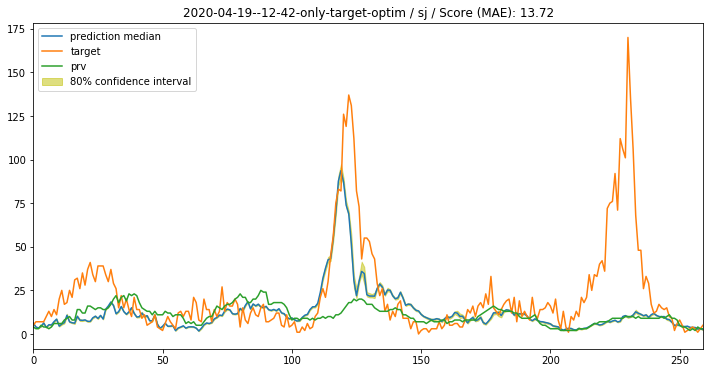

In [62]:
display_quantiles(predictions_sj, target=target_sj, other_predictions_path= './data/submissions/submission_features-scaled-2020-04-14-14-45-36-63.csv', scores=scores)

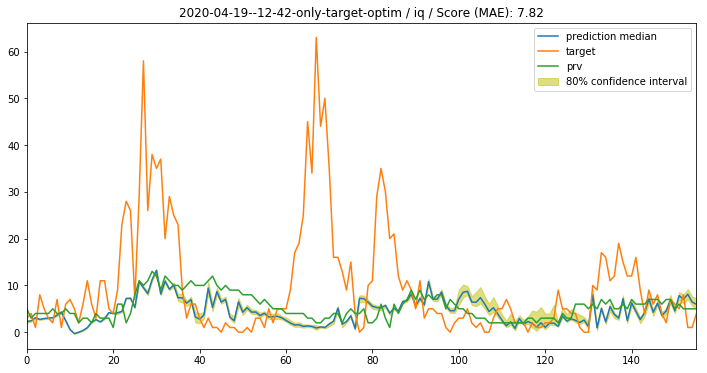

In [63]:
display_quantiles(predictions_iq, target=target_iq, other_predictions_path= './data/submissions/submission_features-scaled-2020-04-14-14-45-36-63.csv', scores=scores)

## Saving our model info

In [64]:
with open('./data/models.infos.csv', 'a+', newline='') as f:
    w = csv.DictWriter(f, fieldnames=model_info_keys)
    if (f.tell()==0):
        w.writeheader()
    w.writerow(current_model_info)

## Train our model on full data and generate a submission

### If we want to skip training and reuse a previously trained model

In [ ]:
from sagemaker.model import Model

def get_model(model_file):
    model_s3_path = f's3://{bucket}/{model_file}'
    model = Model(model_data=model_s3_path,
              image=image_name,
             role=role)
    return model

# estimator_sj = get_model('dengai/all-feat-stdscale-2020-04-09-18-03-41-96/models/dengai-deepar-all-feat-stdscale-SJ-2020-04-09-18-07-55-834/output/model.tar.gz')
# estimator_iq = get_model('dengai/all-feat-stdscale-2020-04-09-18-03-41-96/models/dengai-deepar-all-feat-stdscale-IQ-2020-04-09-18-38-28-653/output/model.tar.gz')

In [65]:
estimator_sj_training_job = fit_model(submission_train_path_sj,
                                      None,
                                      f'{prefix}-{tag}-sj',
                                      {'prediction_length': str(PREDICTION_LENGTH['sj'])})
estimator_iq_training_job = fit_model(submission_train_path_iq,
                                      None,
                                      f'{prefix}-{tag}-iq',
                                      {'prediction_length': str(PREDICTION_LENGTH['iq']),
                                      'num_cells': '64',
                                      'context_length': '32'})

estimator_sj = Estimator.attach(estimator_sj_training_job)
estimator_iq = Estimator.attach(estimator_iq_training_job)

2020-04-19 14:19:14 Starting - Launching requested ML instances......
2020-04-19 14:20:12 Starting - Preparing the instances for training.........
2020-04-19 14:21:35 Downloading - Downloading input data...
2020-04-19 14:22:07 Training - Training image download completed. Training in progress..Arguments: train
[04/19/2020 14:22:10 INFO 140480903202624] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[04/19/2020 14:22:10 INFO 140480903202624] Reading 

In [66]:
transformer_sj_job = batch_transform(estimator_sj, submission_test_path_sj)
transformer_iq_job = batch_transform(estimator_iq, submission_test_path_iq)

transformer_sj = Transformer.attach(transformer_sj_job).wait()
transformer_iq = Transformer.attach(transformer_iq_job).wait()

Transformer created from dengai-only-target-optim-sj-2020-04-19-14-19-13-146
> Transform job dengai-only-target-optim-sj-2020-04-19--2020-04-19-15-00-54-492 created with data: s3://sagemaker-eu-central-1-964501460451/dengai/2020-04-19--12-42-only-target-optim/pprocess_data/submission_test_pp_sj.json
Transformer created from dengai-only-target-optim-iq-2020-04-19-14-19-13-332
> Transform job dengai-only-target-optim-iq-2020-04-19--2020-04-19-15-00-55-024 created with data: s3://sagemaker-eu-central-1-964501460451/dengai/2020-04-19--12-42-only-target-optim/pprocess_data/submission_test_pp_iq.json
......................Arguments: serve
No handlers could be found for logger "root"
[04/19/2020 15:04:26 INFO 140344906811200] Estimated memory required per model 102MB.
[04/19/2020 15:04:26 INFO 140344906811200] Estimated available memory 15078MB.
[04/19/2020 15:04:26 INFO 140344906811200] Estimated maximum number of workers for the available memory is 146.
[04/19/2020 15:04:26 INFO 14034490681

In [67]:
predictions_sj = unjson_prediction(sagemaker.s3.S3Downloader.read_file(predictions_path(s3_batch_output_path, validation_path_sj)))
predictions_iq = unjson_prediction(sagemaker.s3.S3Downloader.read_file(predictions_path(s3_batch_output_path, validation_path_iq)))

## Creating output CSV for submission

In [68]:
def create_submission(predictions_sj, predictions_iq, template_file='./data/input/submission_format.csv', output_dir='./data/submissions'):
    submission = pd.read_csv(template_file)
    submission.loc[submission.city=='iq', 'total_cases'] = predictions_iq['0.5'].tolist()
    submission.loc[submission.city=='sj', 'total_cases'] = predictions_sj['0.5'].tolist()
    submission['total_cases'] = np.maximum(0, submission['total_cases'].round().astype(int))
    submission.to_csv(f'{output_dir}/submission_{model_version}.csv', index=False)

In [69]:
create_submission(predictions_sj, predictions_iq)

In [70]:
submission_score = 30.1755

submission_infos = {
    'model_version': model_version,
    'submission_score': submission_score
}

with open('./data/submissions.infos.csv', 'a+', newline='') as f:
    w = csv.DictWriter(f, fieldnames=submission_infos)
    if (f.tell()==0):
        w.writeheader()
    w.writerow(submission_infos)